In [1]:
import gym
import random
import time
import numpy as np
import pandas as pd
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from IPython.display import clear_output
from collections import deque
from gym.envs.registration import register


# wrap in a try block to supress a warning we don't care about
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#env_name = "CartPole-v1"
#env_name = "MountainCar-v0"
#env_name = "MountainCarContinuous-v0"
#env_name = "Acrobot-v1"
#env_name = "Pendulum-v0"
#env_name = "FrozenLake-v0"
env_name = "FrozenLakeNoSlip-v0"   # we set is_slippery=False in the register up above

env = gym.make(env_name)

type(env.action_space)

gym.spaces.discrete.Discrete

In [3]:
class Agent():
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Action size:", self.action_size)
            
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("Action range:", self.action_low, self.action_high)
        
    def get_action(self, state):
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                      self.action_high,
                                      self.action_shape)
        return action

## Experience Replay

#### Overview:

At each timestep, load a buffer with the experience, then train on a batch sampled from the buffer.

#### Implementation

In the train method, append experiences to a _dequeue_.

use random choices to sampled the dequeueu to the batch.


In [4]:
# QNRAgent is a subclass of the Agent class above

class QNRAgent(Agent):
    def __init__(self, env, discount_rate, learning_rate):
        super().__init__(env)
        
        # Action size already defined above in parent class
        
        # Define and printout state size here:
        self.state_size = env.observation_space.n
        print("State size", self.state_size)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        # build a Q table
        self.build_model()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.replay_buffer = deque(maxlen=1000)
        
    def build_model(self):
        tf.reset_default_graph()   # do this anytime you name things, like the weights down below
        self.state_in = tf.placeholder(tf.int32, shape=[None])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.target_in = tf.placeholder(tf.float32, shape=[None])
        
        self.state = tf.one_hot(self.state_in, depth=self.state_size)
        self.action = tf.one_hot(self.action_in, depth=self.action_size)
        
        self.q_state = tf.layers.dense(self.state, units=self.action_size, name="q_table")
        self.q_action = tf.reduce_sum(tf.multiply(self.q_state, self.action), axis=1)
        
        self.loss = tf.reduce_sum(tf.square(self.target_in - self.q_action))
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    # modify get_action method
    def get_action(self, state):
        q_state = self.sess.run(self.q_state, feed_dict={self.state_in: [state]})
        
        # exploration vs exploitation using probability of epsilon
        action_greedy = np.argmax(q_state)
        action_random = super().get_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience, batch_size=50):
        self.replay_buffer.append(experience)
        samples = random.choices(self.replay_buffer, k=batch_size)
        state, action, next_state, reward, done = (list(col) for col in zip(experience, *samples))
        
        
        #state, action, next_state, reward, done = ([exp] for exp in experience)
        
        # q table
        q_next = self.sess.run(self.q_state, feed_dict={self.state_in: next_state})
        q_next[done] = np.zeros([self.action_size])
        q_target = reward + self.discount_rate * np.max(q_next, axis=1)
        
        feed = {self.state_in: state, self.action_in: action, self.target_in: q_target}
        self.sess.run(self.optimizer, feed_dict=feed)
        
        # Exponential decay of epsilon when reaching a terminal step
        if experience[4]:
            self.eps = self.eps * 0.99
            
    def __del__(self):
        self.sess.close()
        


### Adjusting the simulation loop for training

- env.step returns the next step, so make a variable called next_step
- call train method
- update the state to the next state
- train over a number of episodes
- and track the reward

- printing the q-table is printing the weights

In [5]:
def run(agent):
    total_reward = 0
    
    total_rewards = []
    for ep in range(200):
        state = env.reset()
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train((state,action,next_state,reward,done))
            state = next_state
            total_reward += reward

            print("s:", state, "a:", action)
            print("Episode: {}, Total Reward: {}, eps: {}".format(ep,total_reward,agent.eps))
            env.render()
            with tf.variable_scope("q_table", reuse=True):
                weights = agent.sess.run(tf.get_variable("kernel"))
                print(weights)
            time.sleep(0.5)
            clear_output(wait=True)
            
        total_rewards.append(total_reward)
    return total_rewards
        
            

In [6]:
discount_rate = 0.97
learning_rate = 0.01

agent1 = QNRAgent(env, discount_rate, learning_rate)
run1 = run(agent1)

s: 15 a: 2
Episode: 199, Total Reward: 100.0, eps: 0.13397967485796175
  (Right)
SFFF
FHFH
FFFH
HFFG
[[ 0.17411056  0.29923117  0.3030457   0.09262465]
 [ 0.17417297 -0.55966353  0.32961     0.11821531]
 [ 0.19971377  0.3530754   0.3030817   0.14476278]
 [ 0.2263844  -0.55963     0.3030737   0.11821025]
 [ 0.19982712  0.32550114 -0.555664    0.09249324]
 [-0.40761656  0.30036527 -0.3903852   0.18141025]
 [-0.65892756  0.38128906 -0.5556625   0.14475644]
 [-0.20885691  0.18708187 -0.15366068 -0.13718098]
 [ 0.22649829 -0.5596535   0.35714766  0.11833951]
 [ 0.2262332   0.38116673  0.38530982 -0.7405032 ]
 [ 0.25390345  0.41028982 -0.5556639   0.17225975]
 [ 0.31148344  0.22943735 -0.43908313  0.4954872 ]
 [ 0.16872251  0.3894025   0.02249259 -0.13064   ]
 [-0.658972    0.38123426  0.41437364  0.17217056]
 [ 0.281961    0.411331    0.44435698  0.20037921]
 [-0.39351326 -0.27034563 -0.5268883   0.0456447 ]]


In [7]:
discount_rate = 0.97
learning_rate = 0.001

agent2 = QNRAgent(env, discount_rate, learning_rate)
run2 = run(agent2)

s: 15 a: 2
Episode: 199, Total Reward: 71.0, eps: 0.13397967485796175
  (Right)
SFFF
FHFH
FFFH
HFFG
[[ 0.28875944  0.26056805  0.10507677  0.04008388]
 [ 0.14113028 -0.58202446  0.33965996  0.19587117]
 [ 0.01412433  0.27066234  0.02300213  0.27561173]
 [-0.04417951 -0.39573792  0.00916837 -0.07134372]
 [ 0.32571307  0.29672    -0.44320086  0.26008314]
 [-0.20413736 -0.07198623 -0.37641197  0.5201744 ]
 [-0.37745017  0.29806152 -0.05675265  0.0395227 ]
 [-0.47515565 -0.29514858 -0.28455442  0.46607614]
 [ 0.12477913 -0.46574053  0.45628715  0.12897803]
 [ 0.14659849  0.35253036  0.4314666  -0.42337587]
 [ 0.38002622  0.26160038 -0.281924    0.10750379]
 [-0.38108218  0.47418106 -0.31894875 -0.18194732]
 [ 0.32873428  0.42423457 -0.04108769 -0.54047567]
 [-0.3842066   0.35304186  0.513773    0.35722804]
 [ 0.31231117  0.2803094   0.5437354   0.11791664]
 [-0.21845534  0.5318965  -0.36831334 -0.35080653]]


In [8]:
from matplotlib import pyplot as plt

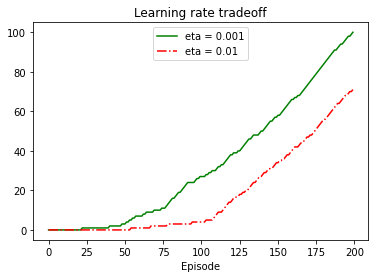

In [11]:
episodes = [ep for ep in range(200)]

plt.plot(episodes, run1, 'g-', label='eta = 0.001')   # green solid line
plt.plot(episodes, run2, 'r-.', label='eta = 0.01') # red dot-dashed line

plt.legend(loc=9) # loc=9 means "top center"
plt.xlabel("Episode")
plt.title("Learning rate tradeoff")
plt.show()